## IR for crime
### given location; get previous crime data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from shapely.geometry import box
from shapely.plotting import plot_polygon, plot_points

import geopandas as gpd

from shapely import STRtree,buffer

import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder

import pointpats
from shapely import Point

#seting up palette 
palette = ["#FAC8BE", "#80E1C6", "#FFB3E1", "#6CC3FC", "#FFD168", "#C894E1"]
sns.set(rc={"axes.facecolor":"#e6e6e6","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap( ["#FAC8BE", "#80E1C6", "#FFB3E1", "#6CC3FC", "#FFD168", "#C894E1"])

In [8]:
# Load the dataset
df = pd.read_csv('./data/crime_dc.csv')

# Display the first 5 rows of the dataset
df.head()

,neighborhood_cluster,offense_group,census_tract,longitude,end_date,offense_text,shift,district,yblock,ward,...,xblock,block,start_date,ccn,offense,anc,report_date,method,location,latitude
0,cluster 38,violent,7404.0,-76.976591,NaN,HOMICIDE,midnight,7.0,131428.00,8.0,...,402032.00,1800 - 1824 block of frederick douglass place se,2023-02-23 16:24:00,23029603,HOMICIDE,8C,2023-02-24 00:00:00,gun,"38.8506559459,-76.9765909045",38.850656
1,cluster 20,violent,9504.0,-76.993575,2023-06-16 18:53:00,ASSAULT W/DANGEROUS WEAPON,day,4.0,140787.56,5.0,...,400557.06,900 - 998 block of michigan avenue ne,2023-06-16 18:29:00,23096959,ASSAULT W/DANGEROUS WEAPON,5B,2023-06-17 11:16:47,others,"38.934972488,-76.9935749549",38.934972
2,cluster 25,property,8410.0,-76.990893,2023-04-13 13:00:00,THEFT/OTHER,midnight,1.0,136927.00,6.0,...,400790.00,1100 - 1199 block of h street ne,2023-04-12 19:30:00,23058339,THEFT/OTHER,6A,2023-04-15 03:15:41,others,"38.900195113,-76.9908927027",38.900195
3,cluster 1,property,3801.0,-77.040824,2023-08-20 22:02:00,THEFT/OTHER,evening,3.0,138822.23,1.0,...,396459.65,1731 - 1785 block of florida avenue nw,2023-08-20 21:10:00,23137253,THEFT/OTHER,1C,2023-08-26 21:56:04,others,"38.9172612211,-77.0408237172",38.917261
4,cluster 6,property,10700.0,-77.040859,2023-05-20 15:54:00,THEFT/OTHER,evening,2.0,137483.00,2.0,...,396456.00,1130 - 1199 block of connecticut avenue nw,2023-05-20 15:40:00,23079620,THEFT/OTHER,2C,2023-05-20 19:48:30,others,"38.9051969682,-77.0408588935",38.905197


In [9]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df=df[df['start_date'].dt.year>2022]

In [10]:
df.index=pd.RangeIndex(start=0,stop=df.shape[0])
# df=df.reset_index()


In [11]:
df['day_of_week'] = df['start_date'].dt.dayofweek
df['hour'] = df['start_date'].dt.hour

In [12]:
# make crime_data a geopanda frame
df['geometry'] = gpd.points_from_xy(df['longitude'], df['latitude'])
crime_data = gpd.GeoDataFrame(df, crs="EPSG:4326")


In [13]:
crime_data

,neighborhood_cluster,offense_group,census_tract,longitude,end_date,offense_text,shift,district,yblock,ward,...,ccn,offense,anc,report_date,method,location,latitude,day_of_week,hour,geometry
0,cluster 38,violent,7404.0,-76.976591,NaT,HOMICIDE,midnight,7.0,131428.00,8.0,...,23029603,HOMICIDE,8C,2023-02-24 00:00:00,gun,"38.8506559459,-76.9765909045",38.850656,3,16,POINT (-76.97659 38.85066)
1,cluster 20,violent,9504.0,-76.993575,2023-06-16 18:53:00,ASSAULT W/DANGEROUS WEAPON,day,4.0,140787.56,5.0,...,23096959,ASSAULT W/DANGEROUS WEAPON,5B,2023-06-17 11:16:47,others,"38.934972488,-76.9935749549",38.934972,4,18,POINT (-76.99357 38.93497)
2,cluster 25,property,8410.0,-76.990893,2023-04-13 13:00:00,THEFT/OTHER,midnight,1.0,136927.00,6.0,...,23058339,THEFT/OTHER,6A,2023-04-15 03:15:41,others,"38.900195113,-76.9908927027",38.900195,2,19,POINT (-76.99089 38.90020)
3,cluster 1,property,3801.0,-77.040824,2023-08-20 22:02:00,THEFT/OTHER,evening,3.0,138822.23,1.0,...,23137253,THEFT/OTHER,1C,2023-08-26 21:56:04,others,"38.9172612211,-77.0408237172",38.917261,6,21,POINT (-77.04082 38.91726)
4,cluster 6,property,10700.0,-77.040859,2023-05-20 15:54:00,THEFT/OTHER,evening,2.0,137483.00,2.0,...,23079620,THEFT/OTHER,2C,2023-05-20 19:48:30,others,"38.9051969682,-77.0408588935",38.905197,5,15,POINT (-77.04086 38.90520)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25850,cluster 23,property,8802.0,-76.988471,2023-05-13 17:21:00,THEFT/OTHER,day,5.0,137671.00,5.0,...,23422572,THEFT/OTHER,5D,2023-06-15 10:02:38,others,"38.9068971135,-76.9884706924",38.906897,5,17,POINT (-76.98847 38.90690)
25851,cluster 24,property,9000.0,-76.960097,2023-08-09 06:45:00,THEFT F/AUTO,day,5.0,140142.00,5.0,...,23130097,THEFT F/AUTO,5C,2023-08-09 11:53:00,others,"38.9291504511,-76.960096837",38.929150,1,21,POINT (-76.96010 38.92915)
25852,cluster 8,property,4702.0,-77.011543,2023-08-16 09:15:00,THEFT/OTHER,day,1.0,136737.04,6.0,...,23135742,THEFT/OTHER,6E,2023-08-18 08:03:43,others,"38.8984836697,-77.01154328",38.898484,2,9,POINT (-77.01154 38.89848)
25853,cluster 15,property,1304.0,-77.058081,2023-09-19 18:18:00,THEFT/OTHER,evening,2.0,140772.69,3.0,...,23154929,THEFT/OTHER,3C,2023-09-19 19:12:25,others,"38.9348242806,-77.0580805327",38.934824,1,18,POINT (-77.05808 38.93482)


In [14]:
tree=STRtree(crime_data['geometry'])

In [ ]:
# need to generate some non-crime events

In [16]:
dc_boundary = gpd.read_file('./data/dc-maps/maps/dc-boundary.geojson')
polygon=dc_boundary['geometry'][0]

In [125]:
# let give a day_of_week and hour, query the dataset to see if it's corresponding to crime
random_location=pointpats.random.poisson(polygon, size=1)
events=tree.query(Point(-77.04,38.91),predicate='dwithin',distance=0.001).tolist()

In [126]:
crime_events=crime_data.iloc[events]

In [127]:
crime_data.iloc[events][['start_date','day_of_week','hour','offense']]

,start_date,day_of_week,hour,offense
2153,2023-06-13 13:52:00,1,13,THEFT/OTHER
17489,2023-01-14 17:51:00,5,17,THEFT/OTHER
17657,2023-01-24 17:00:00,1,17,THEFT F/AUTO
11271,2023-03-27 15:15:00,0,15,THEFT F/AUTO
259,2023-06-04 11:30:00,6,11,BURGLARY
2895,2023-09-30 17:52:00,5,17,THEFT/OTHER
22015,2023-08-18 04:17:00,4,4,BURGLARY
13892,2023-08-02 20:00:00,2,20,THEFT/OTHER
8010,2023-08-24 22:00:00,3,22,THEFT F/AUTO
11244,2023-07-15 17:07:00,5,17,THEFT/OTHER


In [128]:
crime_events['hour'].value_counts().sort_values(ascending=False)

hour
17    4
13    3
15    3
12    3
0     3
4     2
23    2
21    2
18    2
16    2
11    1
20    1
22    1
2     1
3     1
19    1
Name: count, dtype: int64

In [132]:
crime_events['hour'].value_counts().sort_values(ascending=False).index[0]

17

Text(0.5, 1.0, 'Offense type')

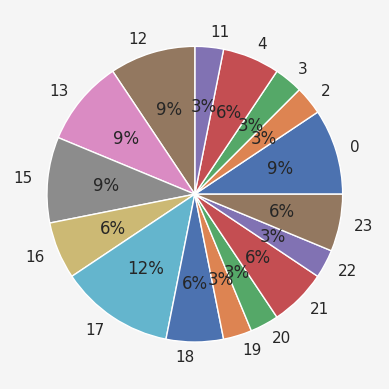

In [130]:
plt.pie(crime_events['hour'].value_counts().sort_index().values,
        labels=crime_events['hour'].value_counts().sort_index().index,autopct='%.0f%%')
ax.set_title('Offense type')

In [74]:
for i in crime_events.index:
    print(crime_events.loc[i,'offense'])

THEFT F/AUTO
MOTOR VEHICLE THEFT
THEFT F/AUTO
THEFT F/AUTO
THEFT/OTHER


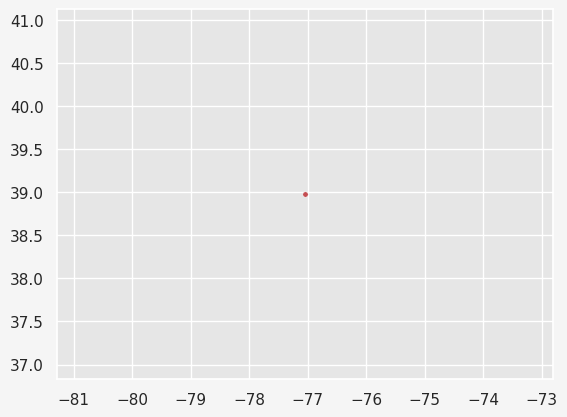

In [55]:
# dc_boundary.plot()
fig,ax=plt.subplots()
sns.scatterplot(x=[random_location[0]],y=[random_location[1]],marker='o',s=15,c='r')
plt.savefig('./temp.png')
# gpd.plot(Point(random_location))